## Escogiendo un algoritmo de clasificación

Cada algoritmo tiene sus cosas buenas y se basa en ciertos supuestos.**No free lunch**, no hay un clasificador que sea mejor que todos en cualquier cosa.

Los pasos para entrenar un algoritmo son los siguientes:

1. Selecciona las variables y colecciona ejemplos de entrenamiento etiquetados.
2. Escoger una métrica de rendimiento.
3. Escoger el algoritmo y entrenar el modelo.
4. Evaluar el rendimiento del modelo.
5. Cambiar las configuraciones del algoritmo y ajustar el modelo.

### Primer paso - Entrenar un perceptrón

Vamos a usar los datos de IRIS.

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()

X = iris.data[:, [2, 3]]
y = iris.target

print('Etiquetas de clase:', np.unique(y))

Etiquetas de clase: [0 1 2]


In [2]:
# Separamos el conjunto de datos en prueba y entrenamiento

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 1, stratify = y
)

Aquí `train_test_split` internamente revuelve los datos, por eso pasamos el argumento `random_state`, también hacemos estratificación con `stratify`, lo que hace que los conjuntos de entrenamiento y prueba tengan la misma proporción de clases que el conjunto de entrada.

In [3]:
print('Conteo de etiquetas en y:      ', np.bincount(y))
print('Conteo de etiquetas en y_train:', np.bincount(y_train))
print('Conteo de etiquetas en y_test: ', np.bincount(y_test))

Conteo de etiquetas en y:       [50 50 50]
Conteo de etiquetas en y_train: [35 35 35]
Conteo de etiquetas en y_test:  [15 15 15]


Muchos algoritmos necesitan escalado de variables para un rendimiento óptimo. Aquí se estandarizan las variables usando `StandardScaler`

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Siempre se ajustan los modelos con los datos de entrenamiento, los datos de prueba se transforman con los mismos parámetros para que sean comparables.

Ahora entrenamos el perceptrón. La mayoría de algoritmos soportan clasifiación multiclase por defecto usando el método **One-versus-rest (OvR)**.

In [5]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0 = 0.1, random_state = 1) # eta0 es la tasa de aprendizaje
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

Una tasa de aprendizaje muy alta no va a encontrar el mínimo global, una tasa de aprendizaje muy baja va a requerir más épocas para convergencia.

Ahora podemos hacer predicciones:

In [6]:
y_pred = ppn.predict(X_test_std)
print('Ejemplos mal clasificados: %d' % (y_test != y_pred).sum())

Ejemplos mal clasificados: 1


El perceptrón tiene un error de mal clasificación de aproximadamente $\frac{1}{45} \approx 0.022$.

Tiene una exactitúd de $1 - \text{error} = 0.978$

Estas métricas ya están implementadas en scikit learn

In [7]:
from sklearn.metrics import accuracy_score

print('Exactitúd: %.3f' % accuracy_score(y_test, y_pred))

Exactitúd: 0.978


In [8]:
# Alternativamente, cada clasificador tiene su propio método de puntaje

print('Exactitúd %.3f' % ppn.score(X_test_std, y_test))

Exactitúd 0.978


Finalmente, podemos graficar las regiones de decisión, agregando los datos de prueba en círculos.


In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def graficar_region_decision(X, y, clasificador, test_idx = None,
                             resolution = 0.02):
    # Configurar los marcadores y el mapa de colores
    marcadores = ('o', 's', '^', 'v', '<')
    colores    = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap       = ListedColormap(colores[:len(np.unique(y))])
    
    # Graficar la superficie de decisión
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    lab = clasificador.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # Graficar las clases de ejemplo
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0],
                    y = X[y == cl, 1],
                    alpha = 0.8,
                    c = colores[idx],
                    marker = marcadores[idx],
                    label = f'clase {cl}',
                    edgecolor = 'black')
    
    # resaltar las clases de prueba
    if test_idx:
        # graficar los ejemplos
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c = 'none', edgecolor = 'black', alpha = 1.0,
                    linewidth = 1, marker = 'o',
                    s = 100, label = 'Conjunto de prueba')
        

Ahora podemos especificar los índices de los ejemplo que queremos marcar en la gráfica.

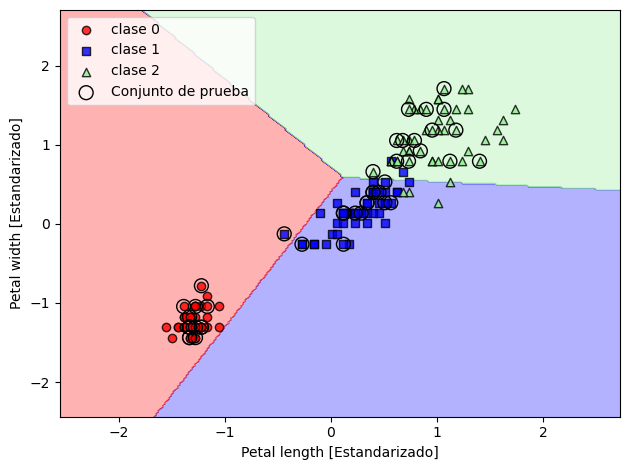

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined     = np.hstack((y_train, y_test))
graficar_region_decision(X = X_combined_std, 
                         y = y_combined,
                         clasificador = ppn,
                         test_idx = range(105, 150))
plt.xlabel('Petal length [Estandarizado]')
plt.ylabel('Petal width [Estandarizado]')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

El perceptrón nunca converge cuando el conjunto de datos no es perfectamente separable linealmente.

### Modelar las probabilidades de clase usando regresión logística

La regresión logística es un modelo para clases separables linealmente para clasificación binaria. (Se puede generalizar para clases multiples **multinomial logistic regression** o **softmax regression**).

Para entender la regresión logística tenemos que entender las probabilidades, las probabilidades de un evento $p$ se pueden escribir como:

$$
\frac{p}{(1-p)}
$$

Ahora definimos la función **logit** como el logaritmo de las probabilidades

$$
logit(p) = \log{\frac{p}{(1-p)}}
$$

Bajo este modelo asumimos que hay una relación lineal entre las entradas ponderadas y la log probabilidad:

$$
\text{logit}(p) = w_1x_1 + \cdots + w_mx_m + b = \sum_{i = j}w_jx_j + b = \mathbf{w^Tx} + b
$$

Nosotros estámos interesado en el valor de $p$el cuál está dado por:\

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Donde $z = \mathbf{w^Tx + b}$.

Vamos a graficar la función sigmoide:

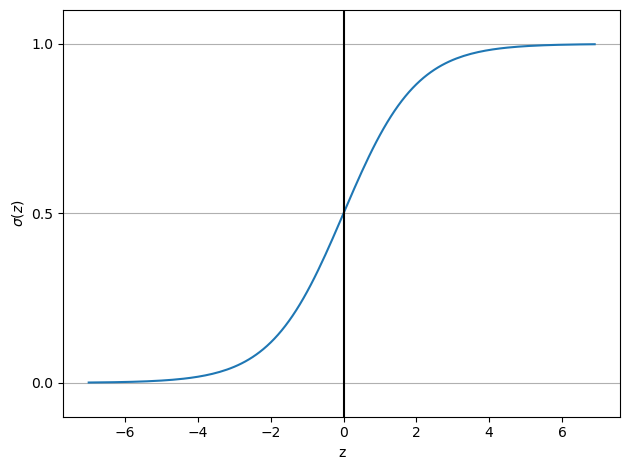

In [11]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color = 'k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

Para este ejemplo, si tuviéramos $\sigma(z) = 0.8$ para una observación, esto significa que hay un $80\%$ de probabilidad que la observación sea Iris-Setosa.

### Aprendiendo los pesos del modelo via la función de perdida logística

Para encontrar los parámetros usamos la verosimilitúd

$$
L(\mathbf{w}, b | \mathbf{x}) = p(y | \mathbf{x};\mathbf{w}, b) = \prod_{i=1}^n (\sigma(z^{(i)}))^{y^{(i)}}(1 - \sigma(z^{(i)}))^{1-y^{(i)}}
$$

Por facilidad se maximiza la log verosimilitúd

$$
l(\mathbf{w}, b | \mathbf{x}) = \log{L(\mathbf{w}, b | \mathbf{x})} = \sum_{i=1}[y^{(i)}\log{(\sigma(z^{(i)}) + (1 - y^{(i)})\log{(1 - \sigma(z^{(i)}))
$$

Ahora usamos un algoritmo de maximización como el ascenso de gradiente para maximizar la log verosimilitúd. Alternativamente, podemos reescribir la log verosimilitúd como una función de perdida, que puede ser minimizada usando descenso de gradiente:

$$
L(\mathbf{w}, b) = \sum_{i=1}^n[-y^{(i)}\log{(\sigma(z^{(i)}) - (1 - y^{(i)})\log{(1 - \sigma(z^{(i)}))
$$  

Veamos una gráfica que muestre la pérdida de clasificar una observación para diferentes valores de $\sigma(z)$ 

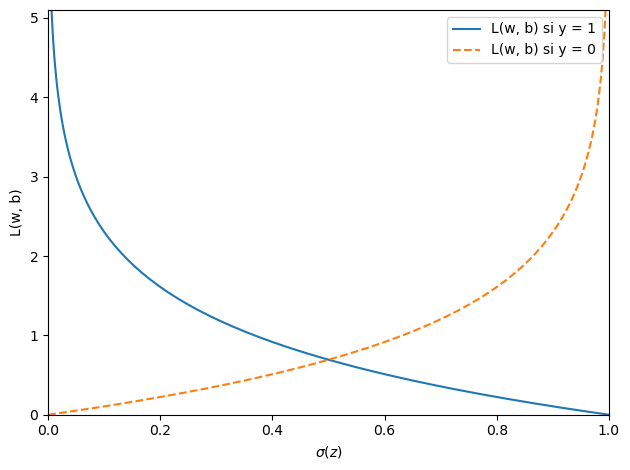

In [12]:
def loss_1(z):
    return - np.log(sigmoid(z))
def loss_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label = 'L(w, b) si y = 1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle = '--', label = 'L(w, b) si y = 0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

La perdida se acerca a 0 si predecimos correctamente que la observación pertenece a la clase 1. Igualmente por la izquierda, la perdida se aproxima a 0 si predecimos y = 0. Si la predicción está mal la perdida se va a infinito.

Vamos a construir una clase para la regresión logística: 

In [13]:
class LogisticRegressionGD:
    ''' Regresión logística basada en el descenso de gradiente
    
    Parámetros
    -------------
    eta           : float
        Tasa de aprendizaje (entre 0.0 y 1)
    n_iter       : int
        Pases sobre el conjunto de entrenamiento.
    random_state : int
        Número aleatorio para generar la semilla para los pesos aleatorios iniciales.
    
    Atributos
    -------------
    w_      : arreglo 1d
        Pesos después del entrenamiento.
    b_      : Escalar
        Sesgo después de ajustar.
    losses_ :
        Función de perdida de error cuadrado medio en cada época.
    '''
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        ''' Ajustar los datos de entrenamiento
        
        Parámetros
        -----------
        
        X: {tipo arreglo}, forma = [n_observaciones, n_variables]
            Vectores de entrenamiento.
        y: {Tipo arreglo}, forma = [n_observaciones]
            Valores target
        
        Returns
        -----------
        self: Instancia de LogisticRegressionGD
    
        '''
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output))
            - ((1 - y).dot(np.log(1 - output)))
            / X.shape[0])
            self.losses_.append(loss)
        return self
            
    def net_input(self, X):
        '''Calcular la net input'''
        return np.dot(X, self.w_) + self.b_

        
    def activation(self, z):
        '''Computar la activación logistica sigmoide'''
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
        
    def predict(self, X):
        '''Devuelve la clase después del paso unitario'''
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

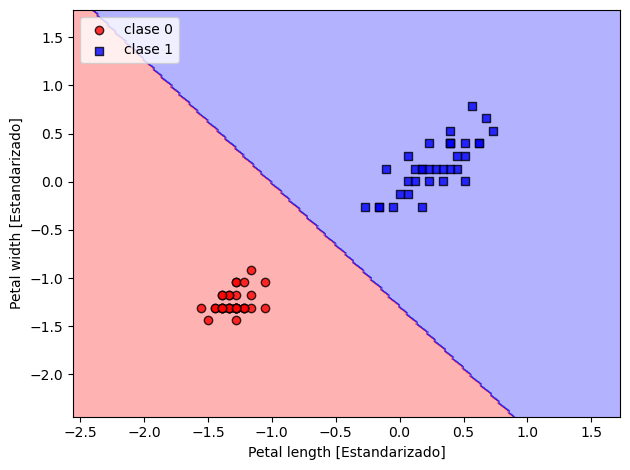

In [14]:
# es binaria, solo funciona para dos clases

X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta = 0.3,
                            n_iter = 1000,
                            random_state = 1)

lrgd.fit(X_train_01_subset,
         y_train_01_subset)

graficar_region_decision(X = X_train_01_subset,
                         y = y_train_01_subset,
                         clasificador=lrgd)

plt.xlabel('Petal length [Estandarizado]')
plt.ylabel('Petal width [Estandarizado]')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()

### Entrenando un modelo logístico con scikit learn



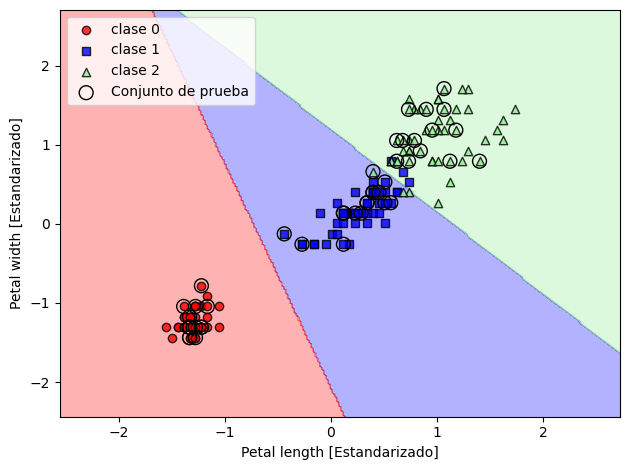

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C = 100.0, solver = 'lbfgs',
                        multi_class='ovr')
lr.fit(X_train_std,y_train)
graficar_region_decision(X_combined_std,
                         y_combined,
                         clasificador = lr,
                         test_idx = range(105, 150))
plt.xlabel('Petal length [Estandarizado]')
plt.ylabel('Petal width [Estandarizado]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

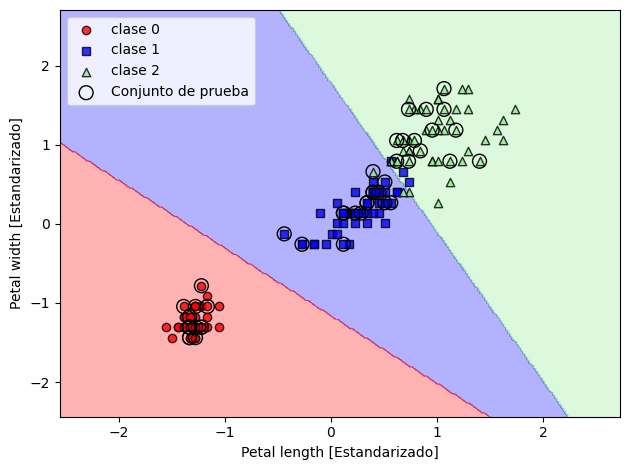

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C = 100.0, solver = 'lbfgs', # Existen mas algoritmos de optimización más avanzados se dan con el parámetro solver
                        multi_class='multinomial')
lr.fit(X_train_std,y_train)
graficar_region_decision(X_combined_std,
                         y_combined,
                         clasificador = lr,
                         test_idx = range(105, 150))
plt.xlabel('Petal length [Estandarizado]')
plt.ylabel('Petal width [Estandarizado]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

La probabilidad que los ejemplos de entrenamiento pertenezcan a cierta clase se pueden computar con el metodo `predict_proba`

In [21]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

La primera fila es para la primera flor, muestra la probabilidad de cada clase. La tercera columna para la primera flor es aproximadamente 0.85, lo que quiere decir que se va a predecir la clase número 3 para la primera observación.

In [22]:
lr.predict_proba(X_test_std[:3, :]).sum(axis = 1) # las sumas de las filas debe dar 1

array([1., 1., 1.])

In [24]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis = 1) # hallar las predicciones de clase usando numpy

array([2, 0, 0], dtype=int64)

In [25]:
lr.predict(X_test_std[:3, :]) # hallar las predicciones de clase

array([2, 0, 0])

In [28]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### Manejando el sobre ajuste con regularización

El problema de sobre ajuste se da cuando el modelo tiene un muy buen rendimiento en los datos de entrenamiento, pero un mal rendimiento en datos no vistos (validación), si el modelo tiene sobre ajuste decimos que tiene una varianza alta. Si el modelo tiene poco ajuste sufre de mucho sesgo y no es capaz de capturar la complejidad de los datos.

Una buena forma de encontrar un buen intercambio entre varianza - sesgo es ajustar la complejidad del modelo con regularización. La regularización es un método util para manejar la colinealidad filtrando ruido de los datos y previniendo el sobre ajuste.

El concepto detrás de la regularización es introducir información adicional que penalice valores extremos de los parámetros. La forma más común de regularización es **L2** la cual es escrita así:

$$
\frac{\lambda}{2n}||\mathbf{w}||^2 = \frac{\lambda}{2n}\sum_{j=1}^mw^2_j
$$

$\lambda$ es llamado el término de regularización. Para la regresión logística el parámetro C es inversamente proporcional al parámetro de regularización $\lambda$. Disminuir C incrementa la regularización lo cual vamos a visualizar:

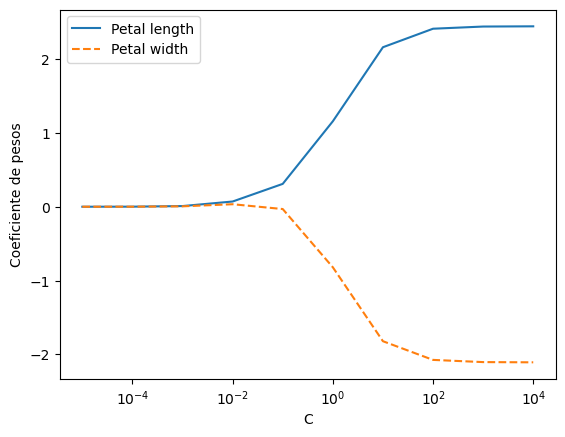

In [31]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c,
                            multi_class = 'ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label = 'Petal length')
plt.plot(params, weights[:, 1], linestyle = '--',
         label = 'Petal width')
plt.ylabel('Coeficiente de pesos')
plt.xlabel('C')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()

El coeficiente de los pesos se encoge si disminuimos el parámetro C, si incrementamos la regularización

Incrementar la fuerza de regularización se puede reducir el sobre ajuste. Incrementar mucho la regularización puede hacer que el modelo tenga un rendimiento bajo y puede tener un bajo ajuste.

### Clasificación de margen máximo con máquinas de soporte vectorial

Los SVM se consideran extensiones del perceptrón. En SVM nuestro objetivo de optimización es maximizar el margen. El margen se define como la distancia que separa el hiperplano y las observaciones de entrenamiento que están más cerca al hiperplano se llaman vectores de soporte.

### Intuición del máximo margen

Se quiere tener límites de decisión con márgenes largos, ya que tienden a tener un error de generalización más bajo.

### Tratando con casos no linealmente separables usando variables **slack**

Estas variables llevan a la **clasificación de margen suave**. Esto permite relajar la optimización objetiva para datos no separables linealmente para permitir la convergencia en presencia de observaciones mal clasificadas.

Esto lleva a la introducción de la variable C en el contexto de SVM. C es un hiperparámetro que controla la penalidad por mal clasificados. Valores grandes de C corresponden a grandes penalidades, si escogemos un C pequeño somos menos estrictos con los mal clasificados. 

Esto está relacionado con la regularización, disminuimos C incrementamos el sesgo y disminuye la varianza.  

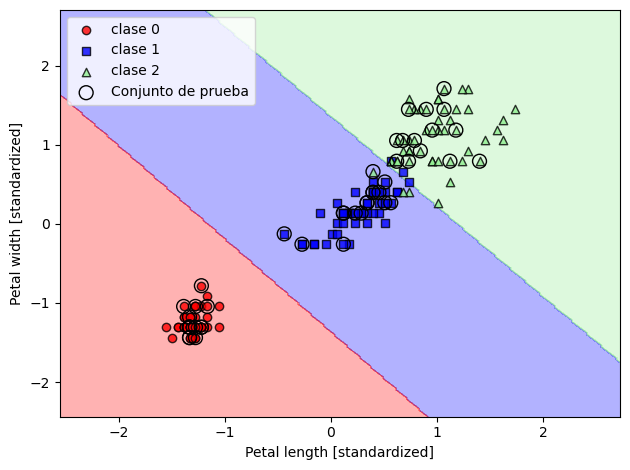

In [32]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train_std, y_train)
graficar_region_decision(X_combined_std,
                         y_combined,
                         clasificador=svm,
                         test_idx = range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Resolviendo problemas no lineales usando un SVM kernel

Los SVM pueden ser kernelizados para resolver problemas de clasificación no lineales.

Se crea un conjunto de datos sintéticos:

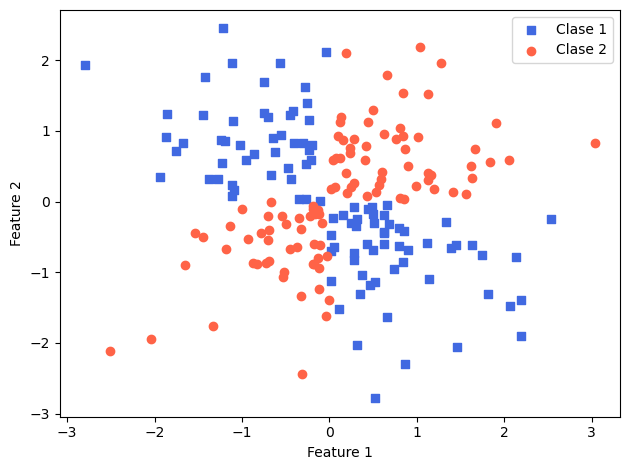

In [35]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c = 'royalblue', marker = 's',
            label = 'Clase 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c = 'tomato', marker = 'o',
            label = 'Clase 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Este conjunto no se puede separar linealmente.

La idea básica detrás del método kernel es crear una combinación no lineal de las características originales para proyectarlas en una dimensión más alta via una función de mapeado. Podemos transformar un conjunto de dos dimensiones a uno de tres dimensiones donde las clases sean separables via la siguiente proyección:

$$
\phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2 + x_2^2)
$$ 

Tenemos los datos, los mapeamos a una dimensión más grande, encontramos un hiperplano que separe las clases, proyectamos de vuelta al espacio original y tendremos nuestro límite de decisión no lineal.

### Usando el truco del kernel para encontrar hiperplanos separables en un espacio de más dimensión

Un problema con el mapeo es que es demasiado costoso computacionalmente. Aquí entra en juego el truco del kernel.

Para entrenar un SVM necesitamos reemplazar el producto punto $x^{(i)T}x^{(j)}$ por $\phi(x^{(i)})^T\phi(x^{(j)})$. Para ahorrarnos este paso costoso, definimos una función kernel:

$$
k(x^{(i)}, x^{(j)}) = \phi(x^{(i)})^T\phi(x^{(j)})
$$

Uno de los kernels más populares es el **radial basis function (RBF)** que puede ser llamado el kernel Gaussiano:

$$
k(x^{(i)}, x^{(j)}) = exp\left(-\frac{||x^{(i)} - x^{(j)}||^2}{2\sigma^2}\right)
$$

o:

$$
k(x^{(i)}, x^{(j)}) = exp(-\lambda||x^{(i)} - x^{(j)}||^2)
$$

Donde $\lambda = \frac{1}{2\sigma^2}$ es un parámetro libre para optimizar.

El kernel puede ser interpretado como una **función de similitúd**, toma un valor de 1 (para observaciones exactamente iguales) y 0 (para observaciones muy diferentes).

Ahora vamos a entrenar un SVC con kernel 'rbf'

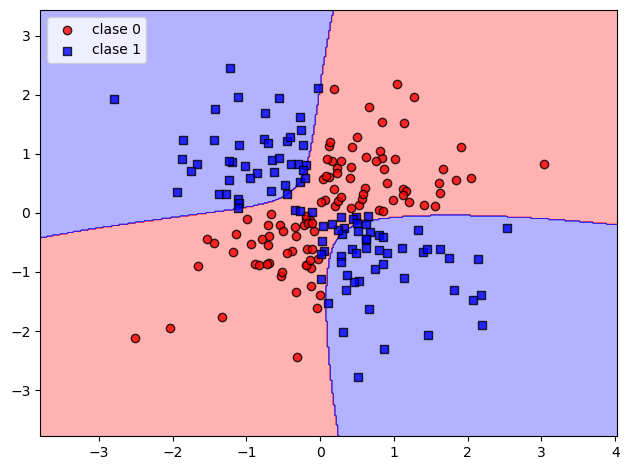

In [36]:
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.10, C = 10.0)
svm.fit(X_xor, y_xor)
graficar_region_decision(X_xor, y_xor, clasificador=svm)
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

$\gamma$ se puede entender como un parámetro de corte para la esfera Gaussiana. Si lo incrementamos, incrementamos la influencia o alcance de las observaciones de entrenamiento.


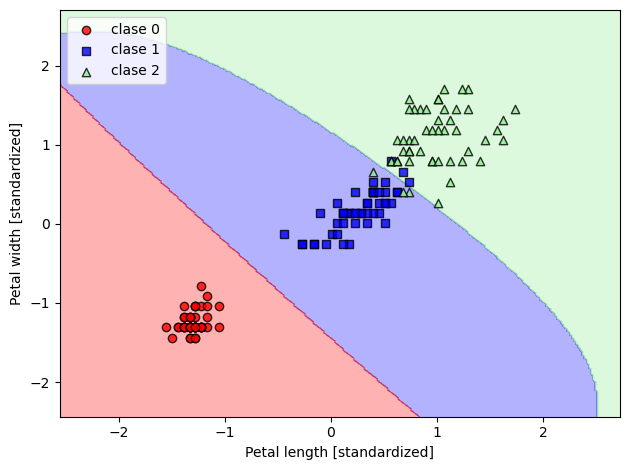

In [37]:
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 0.2, C = 1.0)
svm.fit(X_train_std, y_train)
graficar_region_decision(X_combined_std,
                         y_combined, clasificador=svm)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

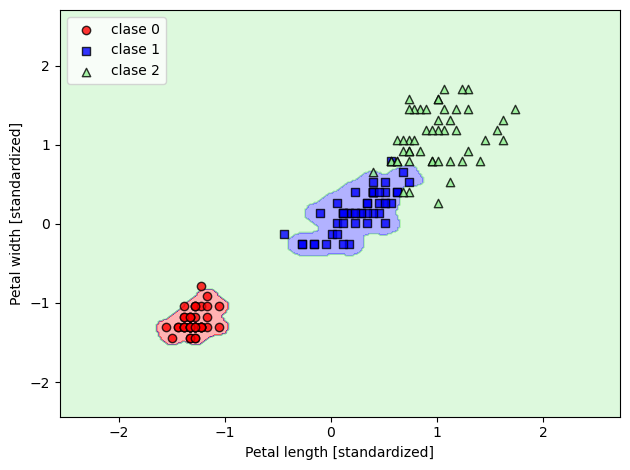

In [38]:
# ahora incrementamos gamma
svm = SVC(kernel = 'rbf', random_state = 1, gamma = 100, C = 1.0)
svm.fit(X_train_std, y_train)
graficar_region_decision(X_combined_std,
                         y_combined, clasificador=svm)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

$\gamma$ controla mucho el sobre ajuste o varianza cuando el algoritmo es muy sensible a las fluctuaciones en el conjunto de entrenamiento.

### Aprendizaje de árboles de decisión

Los árboles de decisión son importantes si nos importa la interpretabilidad. Este modelo se basa en tomar decisiones basadas en una serie de preguntas.

Empezamos la raíz de árbol separando los datos en la variable que resulte en la mayor información ganada (IG), repetimos este proceso hasta que las hojas sean puras. Esto quiere decir, todas las observaciones del nodo pertenecen a la misma clase. Esto puede resultar en un árbol con muchos nodos, por lo tanto, puede llevar al sobre ajuste. Por eso se **poda** el árbol estableciendo un límite para la máxima profundidad.

#### Maximizando IG 

Para dividir los nodos en las variables más informativas, necesitamos una función objetivo para optimizar. Aquí buscamos maximizar la IG en cada división la cual se define como:

$$
IG(D_p, f) = I(D_p) - \sum_{j=1}^m \frac{N_j}{N_p}I(D_j)
$$

$f$ es la variable para hacer la división; $D_p$ y $D_j$ son los conjuntos de datos del padre y j-esimo nodo hijo, I es la medida de **impureza**; $N_p$ es el número total de observaciones en el nodo padre y $N_j$ es el número de observaciones en el nodo hijo.

La medida de impureza del árbol que son más comunes son **Impureza de Gini $(I_G)$**, **Entropía $(I_H)$** y **el error de clasificación $(I_E)$**. Para empezar, la entropía:

$$
I_H(y) = - \sum_{i=1}^cp(i|t)\log_2{p(i|t)}
$$ 

$p(i|t)$ es la proporción de observaciones que pertenecen a la clase $i$ para un nodo particular $t$. 

Visualicemos la entropía



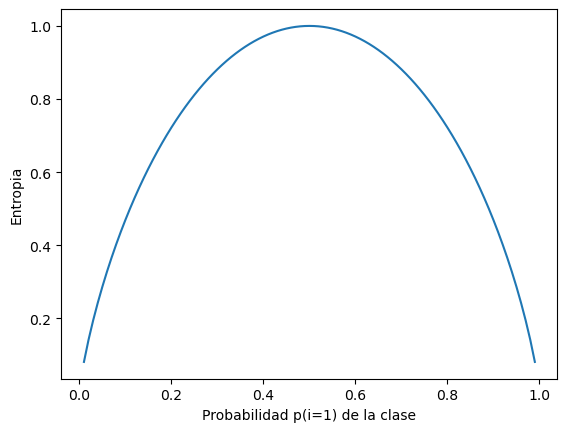

In [39]:
def entropia(p):
    return - p * np.log2(p) - (1-p) * np.log2((1 - p))
x = np.arange(0.0, 1.0, 0.01)
ent = [entropia(p) if p != 0 else None for p in x]
plt.ylabel('Entropia')
plt.xlabel('Probabilidad p(i=1) de la clase')
plt.plot(x, ent)
plt.show()

Veamos las tres medidas de impureza

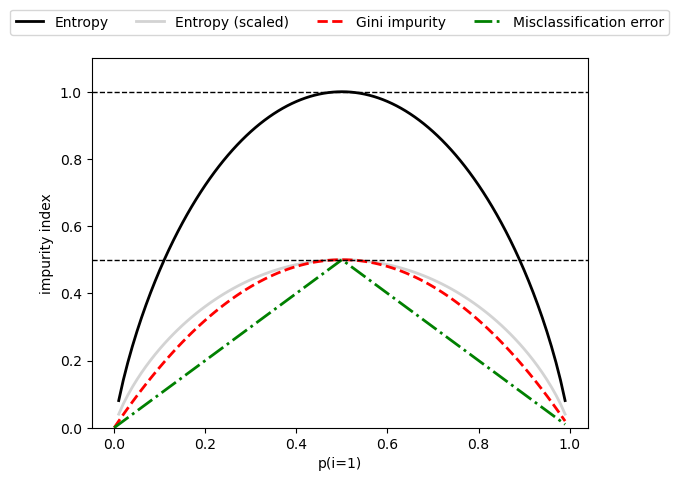

In [41]:
def gini(p):
    return p*(1 - p) + (1 - p)*(1 - (1-p))
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
     ['Entropy', 'Entropy (scaled)',
     'Gini impurity',
     'Misclassification error'],
     ['-', '-', '--', '-.'],
     ['black', 'lightgray',
     'red', 'green', 'cyan']):
     line = ax.plot(x, i, label=lab,
     linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
         ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

### Construyendo un árbol de decisión

Estos modelos crean decisiones de espacios rectangulares, entre más profundo un árbol más tiende a sobre ajustar. Aquí construimos un árbol con profundidad 4 usando la impureza de Gini como criterio de impureza. **Escalar las variables no es necesario para los árboles de decisión**.

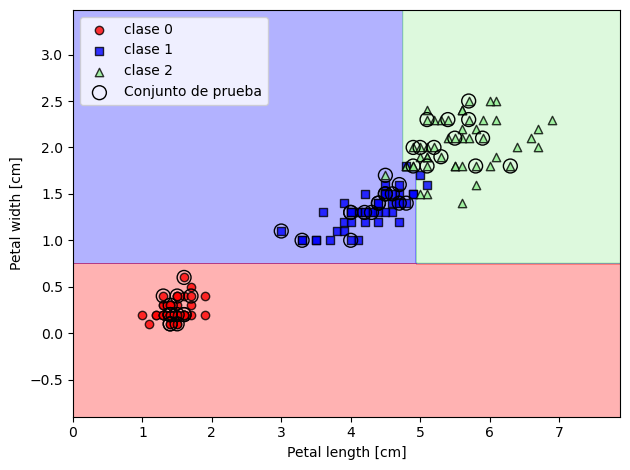

In [43]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion = 'gini',
                                    max_depth = 4,
                                    random_state = 1)

tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
graficar_region_decision(X_combined, 
                         y_combined,
                         clasificador=tree_model,
                         test_idx= range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Podemos visualizar el árbol después del entrenamiento

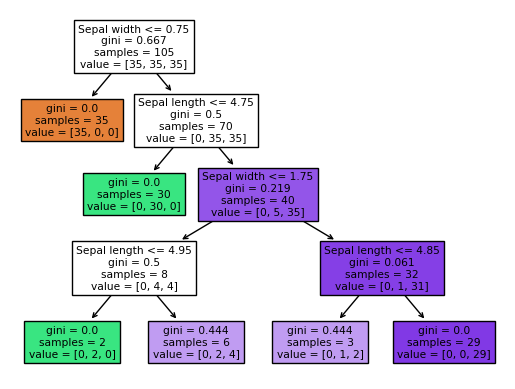

In [45]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']

tree.plot_tree(tree_model, 
               feature_names=feature_names,
               filled=True)
plt.show()

# Los nodos a la izquierda son verdadero y a la derecha falsos

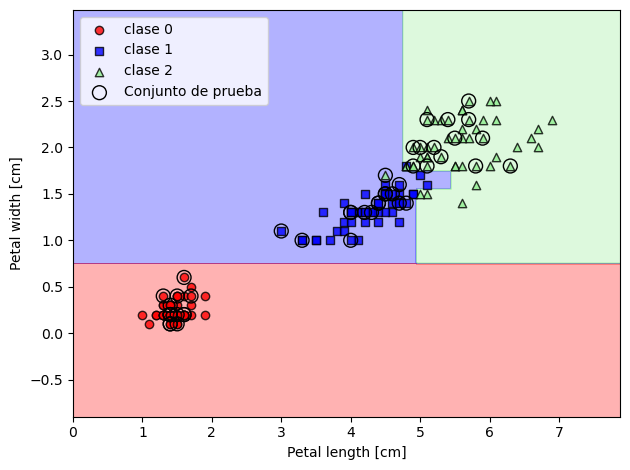

In [46]:
tree_model2 = DecisionTreeClassifier(criterion = 'gini',
                                    max_depth = 6,
                                    random_state = 1)

tree_model2.fit(X_train, y_train)


graficar_region_decision(X_combined, 
                         y_combined,
                         clasificador=tree_model2,
                         test_idx= range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

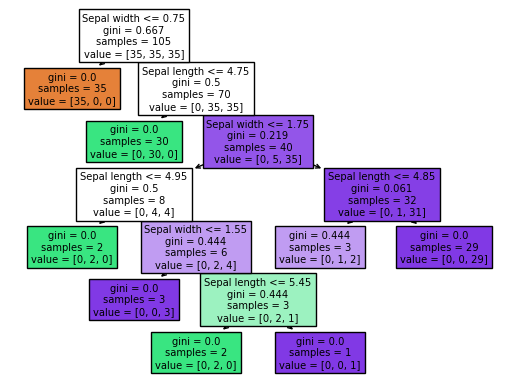

In [47]:
tree.plot_tree(tree_model2, 
               feature_names=feature_names,
               filled=True)
plt.show()

# Aquí probablemente haya sobre ajuste

### Combinando árboles de decisión via random forest

Random forest es un tipo de modelo de ensamblaje de árboles de decisión. La idea es promediar muchos árboles que por si solos sufren de varianza alta para construir un mejor modelo más robusto menos susceptible a sobre ajuste. El algoritmo se puede referir como:

1. Escoger una muestra aleatoria **bootstrap** de tamaño n. 
2. Crecer un árbol de decisión de la muestra bootstrap. En cada nodo:
   a. Escoger aleatoriamente d variables sin reemplazo.
   b. Dividir el nodo usando la variable que provea la mejor división.
3. Repetir pasos 1 y 2 k veces.
4. Agregar la predicción de cada árbol para asignar la etiqueta de clase por un voto de mayoría.

Los random forest pierden en interpretabilidad una característica importante es que no debemos preocuparnos por escoger buenos hiperparámetros. El único parámetro por preocuparnos es el número de árboles, otros parámetros se pueden ajustar (se van a ver en capítulos siguientes) 

Disminuyendo el tamaño de las muestras bootstrap incrementa la diversidad de los árboles y puede ayudar a reducir el sobre ajuste per perdiendo rendimiento. Para las variables se escoge $\sqrt{m}$.

 

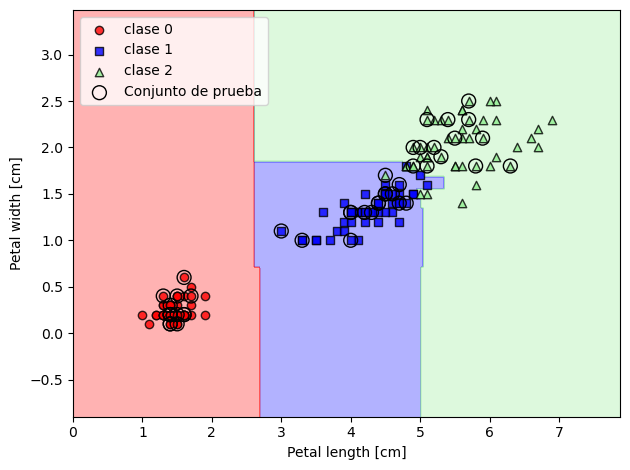

In [50]:
from sklearn.ensemble import RandomForestClassifier

# Automáticamente usa la impureza de Gini

forest = RandomForestClassifier(n_estimators = 25, # 25 árboles
                                random_state = 1,
                                n_jobs = 2)  # procesadores a usar 

forest.fit(X_train, y_train)
graficar_region_decision(X_combined, y_combined,
                         clasificador=forest, test_idx = range(105, 150))
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

### KNN 

Este algorítmo no aprende una función discriminante del conjunto de entrenamiento si no que memoriza el conjunto de entrenamiento.

1. Escoger un número de k vecinos y una métrica de distancia.
2. Encontrar los k vecinos más cercanos de los datos que queremos clasificar.
3. Asignar la etiqueta de clase por voto de mayoría.

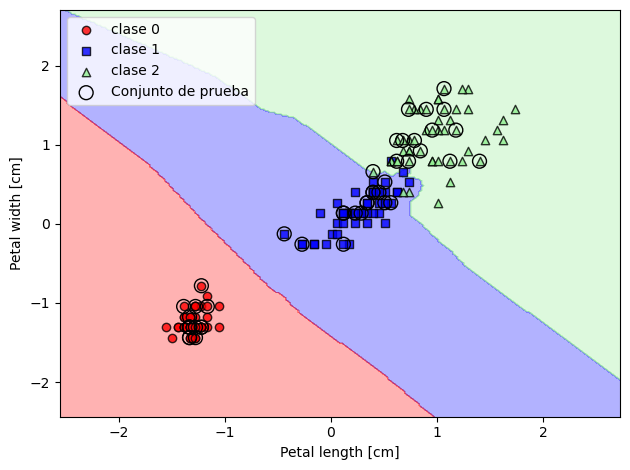

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, p = 2,
                           metric = 'minkowski')
knn.fit(X_train_std, y_train)
graficar_region_decision(X_combined_std, y_combined,
                         clasificador=knn, test_idx = range(105, 150))
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

Es muy importante escoger bien k, también debemos asegurarnos de escoger una métrica de distancia apropiada para las variables. Si usamos la distancia euclidiana es importante estandarizar las variables. La **minkowski** es una generalización de la distancia euclideana y manhattan.

$$
d(x^{(i)}, x^{(j)}) = \sqrt[p]{\sum_k |x^{(i)}_k - x^{(j)}_k|^p}
$$

Se vuelve la distancia euclideana con $p = 2$ o Manhattan con $p = 1$.

KNN es muy susceptible a sobre ajustar por la maldición de la dimensionalidad.  